In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import re
import json
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from scipy.stats import ttest_ind
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.weightstats import DescrStatsW
import itertools
from statsmodels.stats.multitest import multipletests
from pypalettes import get_hex

## Dataset import

In [3]:
with open("Corriere.json", 'r', encoding='utf-8') as file:
    data = json.load(file)

def extract_tag_from_link(link):
    match = re.search(r'corriere\.it/([^/]+)/', link)
    if match:
        return match.group(1)
    return None

news_list = []
for item in data["news"]:
    tag = extract_tag_from_link(item.get("Link", ""))
    news_list.append({
        "Tag": tag
    })

df = pd.DataFrame(news_list)
translation_map = {
    'esteri': 'foreign',
    'salute': 'health',
    'politica': 'politics',
    'scuola': 'school',
    'sport': 'sports',
    'cronache': 'chronicles',
    'economia': 'economy'
}
df['Tag'] = df['Tag'].replace(translation_map)

In [4]:
df2 = pd.read_json("sentence_diff_2.json")
df2 = pd.merge(df2, df, left_index=True, right_index=True)
df4 = pd.read_json("sentence_diff_4.json")
df4= pd.merge(df4, df, left_index=True, right_index=True)
df6 = pd.read_json("sentence_diff_6.json")
df6= pd.merge(df6, df, left_index=True, right_index=True)
df8 = pd.read_json("sentence_diff_8.json")
df8= pd.merge(df8, df, left_index=True, right_index=True)
dftot = pd.concat([df2,df4,df6, df8]).reset_index()

def mean_ignore_none(lst):
    filtered_list = [x for x in lst if x is not None]
    return np.mean(filtered_list) if filtered_list else None

# Average distance
dftot["mean_euclidean_distance"] = dftot["euclidean_distance"].apply(mean_ignore_none)

In [9]:
df2.head()

,window_size,euclidean_distance,dot_product,Tag
0,2,"[0.593776762485504, 0.9253675937652581, 0.9403...","[0.8237146139144891, 0.5718473196029661, 0.557...",foreign
1,2,"[0.974475681781768, 1.1313226222991941, 1.1270...","[0.525198578834533, 0.360054671764373, 0.36491...",foreign
2,2,"[0.9527560472488401, 1.277578830718994, 1.2187...","[0.546127915382385, 0.18389624357223502, 0.257...",foreign
3,2,"[0.753161787986755, 0.8683400154113771, 0.9656...","[0.7163736820220941, 0.622992873191833, 0.5337...",foreign
4,2,"[0.9932721853256221, 0.944851338863372, 1.0970...","[0.506705105304718, 0.553627967834472, 0.39821...",foreign


In [5]:
summary = dftot.groupby(by="window_size")["mean_euclidean_distance"].describe()
summary

,count,mean,std,min,25%,50%,75%,max
window_size,,,,,,,,
2,1151.0,1.006030,0.064976,0.726468,0.964301,1.011584,1.055600,1.141726
4,1150.0,0.858140,0.060462,0.608155,0.818162,0.860785,0.903818,1.036705
6,1135.0,0.796758,0.062402,0.499031,0.755784,0.800342,0.842634,0.987812
8,1106.0,0.757483,0.062761,0.530019,0.714724,0.761901,0.804429,0.938247


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pypalettes/deprecated.py:71: DeprecationWarning: 
The get_hex() function is deprecated and will be removed in a future version.
Please, use: load_cmap('CafeDeNuit').hex

  warnings.warn(warning_message, category=DeprecationWarning)
/Users/giuliodonninelli/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/giuliodonninelli/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/giuliodonninelli/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are manag

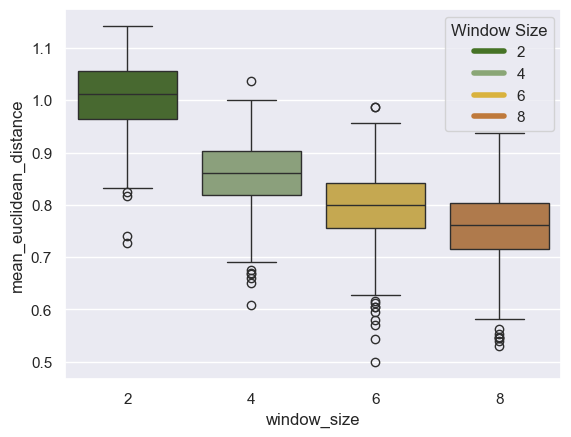

In [6]:
sns.set_theme(style="darkgrid")
palette = get_hex("CafeDeNuit", keep_first_n=4)

sns.boxplot(x=dftot["window_size"], y=dftot["mean_euclidean_distance"], palette=palette, legend=True)
handles = [plt.Line2D([0], [0], color=palette[i], lw=4) for i in range(len(palette))]
labels = dftot["window_size"].unique()
plt.legend(handles, labels, title="Window Size", loc="best")
plt.show()

# ANOVA analysis between groups

In [7]:
WINDOW_SIZE = [2, 4, 6, 8]
data = []
groups = []

for size in WINDOW_SIZE:
    group_data = dftot[dftot["window_size"] == size]["mean_euclidean_distance"].dropna()
    data.append(group_data)
    groups += [f'group_{size}'] * len(group_data)

dfANOVA = pd.DataFrame({'data': np.concatenate(data), 'group': groups})
model = ols('data ~ group', data=dfANOVA).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   data   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     3448.
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:04:53   Log-Likelihood:                 6137.8
No. Observations:                4542   AIC:                        -1.227e+04
Df Residuals:                    4538   BIC:                        -1.224e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0060      0.002    544.601      0.000       1.002       1.010
group[T.group_4]    -0.1479      0.003    -56.597      0.000      -0.153      -0.143
group[T.group_6]    -0.2093      0.003    -79.825      0.000      -0.214      -0.204
group[T.group_8]    -0.2485      0.003    -94.187      0.000      -0.254      -0.243
==============================================================================
Omnibus:                      122.305   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.031
Skew:                          -0.404   Prob(JB):                     2.14e-29
Kurtosis:                       3.212   Cond. No.                         4.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Hypothesis testing

In [8]:
group_2 = dftot[dftot["window_size"] == 2]["mean_euclidean_distance"].dropna()
group_4 = dftot[dftot["window_size"] == 4]["mean_euclidean_distance"].dropna()
group_6 = dftot[dftot["window_size"] == 6]["mean_euclidean_distance"].dropna()
group_8 = dftot[dftot["window_size"] == 8]["mean_euclidean_distance"].dropna()

# Homoschedacity
print("Homoschedacity:")
stat, p_value = stats.levene(group_2, group_4, group_6, group_8)
print(f"• F-statistic: {stat}")
print(f"• P-value: {p_value:.4f}")

Homoschedacity:
• F-statistic: 1.9008760192596763
• P-value: 0.1272


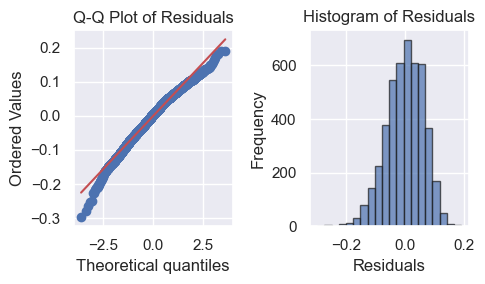

Normality:
• F-statistic: 0.9899162932000426
• P-value: 0.0000


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Q-Q Plot of residuals
sns.set_theme(style="darkgrid")
stats.probplot(model.resid, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot of Residuals")

# Histogram of residuals
axes[1].hist(model.resid, bins=20, edgecolor='k', alpha=0.7)
axes[1].set_title("Histogram of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

print("Normality:")
stat, p_value = stats.shapiro(model.resid)
print(f"• F-statistic: {stat}")
print(f"• P-value: {p_value:.4f}")


Homoschedasticity hypotehsis is respected while the normality isn't this is not a big problem since we have more than 3,000 observation thus the TCL guarantee that the estimates are robusts.

## Contrast Analysis

In [ ]:
mc = MultiComparison(dfANOVA['data'], dfANOVA['group'])
def pairwise_ttest(x, y):
    # Perform a two-sample t-test
    stat, p_value = ttest_ind(x, y)
    return stat, p_value

bonferroni_result = mc.allpairtest(pairwise_ttest, method='bonf')[0]

print(bonferroni_result)

Test Multiple Comparison pairwise_ttest 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
 group1  group2   stat  pval pval_corr reject
---------------------------------------------
group_2 group_4 56.5169  0.0       0.0   True
group_2 group_6 78.5224  0.0       0.0   True
group_2 group_8 92.3753  0.0       0.0   True
group_4 group_6 23.8805  0.0       0.0   True
group_4 group_8 38.7991  0.0       0.0   True
group_6 group_8 14.8538  0.0       0.0   True
---------------------------------------------


All four contrasts are meaningfull so the best thing to do is use a context window of 6/8 phrases

## ANOVA analysis between categories

In [ ]:
dfgroup = dftot.groupby(by="Tag")["mean_euclidean_distance"].describe()
dfgroup

,count,mean,std,min,25%,50%,75%,max
Tag,,,,,,,,
chronicles,636.0,0.876165,0.114467,0.499031,0.794905,0.856701,0.953663,1.126312
economy,784.0,0.840671,0.110605,0.544083,0.762866,0.826276,0.923654,1.113113
foreign,765.0,0.864612,0.110073,0.617242,0.785434,0.839664,0.948958,1.135911
health,618.0,0.808277,0.102239,0.546171,0.733809,0.790094,0.878566,1.092030
politics,622.0,0.885275,0.106110,0.685368,0.806858,0.860156,0.958234,1.132321
school,212.0,0.791488,0.093216,0.579643,0.723301,0.766927,0.862179,1.063124
sports,905.0,0.874243,0.117123,0.530019,0.799490,0.857889,0.945531,1.141726


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pypalettes/deprecated.py:71: DeprecationWarning: 
The get_hex() function is deprecated and will be removed in a future version.
Please, use: load_cmap('CafeDeNuit').hex

  warnings.warn(warning_message, category=DeprecationWarning)
/var/folders/46/lfv4tflx1ngf6vjmk2_qtxx80000gn/T/ipykernel_19194/2533197384.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dftot["Tag"], y=dftot["mean_euclidean_distance"], palette=palette, legend=True)
/var/folders/46/lfv4tflx1ngf6vjmk2_qtxx80000gn/T/ipykernel_19194/2533197384.py:4: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x=dftot["Tag"], y=dftot["mean_euclidean_distance"], palette=palette, legend=True)


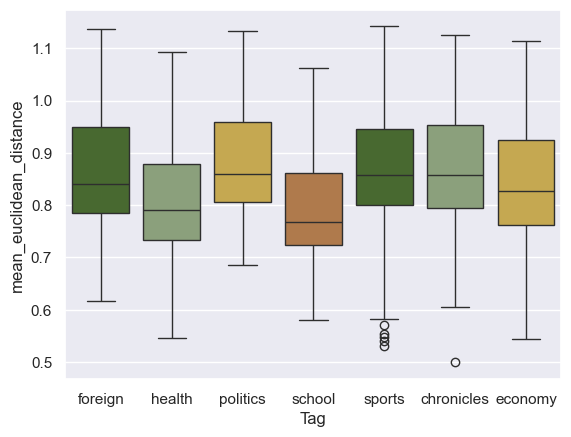

In [ ]:
sns.set_theme(style="darkgrid")
palette = get_hex("CafeDeNuit", keep_first_n=4)

sns.boxplot(x=dftot["Tag"], y=dftot["mean_euclidean_distance"], palette=palette, legend=True)
plt.show()

In [ ]:
unique_values = dftot["Tag"].unique()
groups = [dftot[dftot["Tag"] == tag]["mean_euclidean_distance"].dropna() for tag in unique_values]

print("Homoschedasticity:")
stat, p_value = stats.levene(*groups)
print(f"• F-statistic: {stat}")
print(f"• P-value: {p_value:.4f}")

Homoschedasticity:
• F-statistic: 3.25232408101052
• P-value: 0.0034


There is heteroschedasticity so I use a robust ANOVA

In [ ]:
welch_result = anova_oneway(groups, use_var="unequal")

# Display results
print("Welch's ANOVA Test:")
print(f"• F-statistic: {welch_result.statistic:.4f}")
print(f"• P-value: {welch_result.pvalue:.4f}")

Welch's ANOVA Test:
• F-statistic: 56.9051
• P-value: 0.0000


In [ ]:
model = ols('mean_euclidean_distance ~ C(Tag)', data=dftot).fit()
tags = dftot['Tag'].unique()
ls_means = {}

for tag in tags:
    group_data = dftot[dftot['Tag'] == tag]['mean_euclidean_distance'].dropna()
    weighted_stats = DescrStatsW(group_data)
    ls_means[tag] = weighted_stats.mean

# Display LS Means
print("\nLeast Squares Means:")
for tag, ls_mean in ls_means.items():
    print(f"• {tag}: {ls_mean:.4f}")


Least Squares Means:
• foreign: 0.8646
• health: 0.8083
• politics: 0.8853
• school: 0.7915
• sports: 0.8742
• chronicles: 0.8762
• economy: 0.8407


Lsmeans are still unbiased

In [ ]:
groups = {tag: dftot[dftot["Tag"] == tag]["mean_euclidean_distance"].dropna() for tag in tags}

p_values = []
pairs = list(itertools.combinations(tags, 2))

for tag1, tag2 in pairs:
    group1 = groups[tag1]
    group2 = groups[tag2]

    _, p_value = ttest_ind(group1, group2, equal_var=False)
    p_values.append(p_value)

adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

# Display pairwise comparison results with Bonferroni correction
print("\nPairwise Comparisons with Welch's t-test and Bonferroni Correction:")
for (tag1, tag2), p_value, adj_p_value in zip(pairs, p_values, adjusted_p_values):
    if adj_p_value > 0.05/21:
        print(f"• {tag1} vs {tag2}:")
        print(f"    Bonferroni-adjusted p-value: {p_value:.4f}")


Pairwise Comparisons with Welch's t-test and Bonferroni Correction:
• foreign vs politics:
    Bonferroni-adjusted p-value: 0.0004
• foreign vs sports:
    Bonferroni-adjusted p-value: 0.0838
• foreign vs chronicles:
    Bonferroni-adjusted p-value: 0.0558
• health vs school:
    Bonferroni-adjusted p-value: 0.0279
• politics vs sports:
    Bonferroni-adjusted p-value: 0.0559
• politics vs chronicles:
    Bonferroni-adjusted p-value: 0.1433
• sports vs chronicles:
    Bonferroni-adjusted p-value: 0.7479


# Singular element analysis

In [ ]:
dataframes = {2: df2, 4: df4, 6: df6, 8: df8}

for i, df in dataframes.items():
    df.drop(columns=["dot_product", "Tag"], inplace=True)  # Ensure the drop is in place
    df.rename(columns={
        "euclidean_distance": f"euclidean_distance_{i}",
        "window_size": f"window_size_{i}",
    }, inplace=True)

In [ ]:
df24 = pd.merge(df2, df4, how="left", left_index=True, right_index=True)
df246 = pd.merge(df24, df6, how="left", left_index=True, right_index=True)
dfcomplete = pd.merge(df246, df8, how="left", left_index=True, right_index=True)

In [ ]:
def calculate_all_differences(row):
    dist_2 = row[f'euclidean_distance_2']
    dist_4 = row[f'euclidean_distance_4']
    
    # Ensure both lists are of the same length by filling the shorter list with None
    length = max(len(dist_2), len(dist_4))
    dist_2 = dist_2 + [None] * (length - len(dist_2))
    dist_4 = dist_4 + [None] * (length - len(dist_4))
    
    # Calculate the differences and handle None values
    differences = [
        (d2 - d4) if d2 is not None and d4 is not None else None
        for d2, d4 in zip(dist_2, dist_4)
    ]
    
    return differences

# Apply the function to calculate differences and create a new column
dfcomplete['all_differences'] = dfcomplete.apply(calculate_all_differences, axis=1)

dfcomplete

,window_size_2,euclidean_distance_2,window_size_4,euclidean_distance_4,window_size_6,euclidean_distance_6,window_size_8,euclidean_distance_8,all_differences
0,2,"[0.593776762485504, 0.9253675937652581, 0.9403...",4,"[None, 0.858475446701049, 0.8305394649505611, ...",6,"[None, None, 0.7024485468864441, 0.64347136020...",8,"[None, None, None, 0.6302142739295961, 0.61111...","[None, 0.0668921470642091, 0.10979199409484897..."
1,2,"[0.974475681781768, 1.1313226222991941, 1.1270...",4,"[None, 0.764722168445587, 0.8643780946731561, ...",6,"[None, None, 0.5766438841819761, 0.77886104583...",8,"[None, None, None, 0.5933482646942131, 0.72176...","[None, 0.36660045385360707, 0.262636661529541,..."
2,2,"[0.9527560472488401, 1.277578830718994, 1.2187...",4,"[None, 0.82378751039505, 0.914114415645599, 0....",6,"[None, None, 0.793345034122467, 0.813191533088...",8,"[None, None, None, 0.7432057261466981, 0.78506...","[None, 0.45379132032394387, 0.3046303391456600..."
3,2,"[0.753161787986755, 0.8683400154113771, 0.9656...",4,"[None, 0.698574662208557, 0.7889913320541381, ...",6,"[None, None, 0.67643517255783, 0.7430857419967...",8,"[None, None, None, 0.631591200828552, 0.655234...","[None, 0.16976535320282005, 0.1766459941864010..."
4,2,"[0.9932721853256221, 0.944851338863372, 1.0970...",4,"[None, 0.767943322658538, 0.8093457818031311, ...",6,"[None, None, 0.783748507499694, 0.695438504219...",8,"[None, None, None, 0.582784533500671, 0.727456...","[None, 0.17690801620483398, 0.2877295613288879..."
...,...,...,...,...,...,...,...,...,...
1147,2,"[1.167036771774292, 1.155124068260192, 1.18053...",4,"[None, 0.7925360202789301, 1.048641681671142, ...",6,"[None, None, 0.788664460182189, 0.890004754066...",8,"[None, None, None, 0.794949233531951, 0.872105...","[None, 0.3625880479812619, 0.13189709186554, 0..."
1148,2,"[0.816122949123382, 0.866814732551574, 0.92004...",4,"[None, 0.6059331297874451, 0.693464815616607, ...",6,"[None, None, 0.699070990085601, 0.840194225311...",8,"[None, None, None, 0.832721054553985, 0.850334...","[None, 0.260881602764129, 0.22657978534698509,..."
1149,2,"[0.8519312739372251, 0.7536856532096861, 1.005...",4,"[None, 0.6771196126937861, 0.9601534008979791,...",6,"[None, None, 0.85606449842453, 0.9134048819541...",8,"[None, None, None, 0.8667610287666321, 0.76712...","[None, 0.07656604051589999, 0.0448597073554999..."
1150,2,"[0.958020448684692, 1.099503993988037, 1.11854...",4,"[None, 0.625475823879241, 0.7209340929985041, ...",6,"[None, None, 0.57787799835205, 0.7163527607917...",8,"[None, None, None, 0.6442818045616151, 0.63574...","[None, 0.47402817010879605, 0.3976091742515569..."
